In [1]:
import json
import time
import os
import operator
import numpy as np
import h5py
import torch
import re

from collections import defaultdict
from torch.utils.data import DataLoader, Dataset
def basic_clean_str(string):
    """Tokenization/string cleaning for a datasets.
    """
    string = re.sub(r"\n", " ", string)  # '\n'      --> ' '
    string = re.sub(r"\'s", " \'s", string)  # it's      --> it 's
    string = re.sub(r"\’s", " \'s", string)
    string = re.sub(r"\'ve", " have", string)  # they've   --> they have
    string = re.sub(r"\’ve", " have", string)
    string = re.sub(r"\'t", " not", string)  # can't     --> can not
    string = re.sub(r"\’t", " not", string)
    string = re.sub(r"\'re", " are", string)  # they're   --> they are
    string = re.sub(r"\’re", " are", string)
    string = re.sub(r"\'d", "", string)  # I'd (I had, I would) --> I
    string = re.sub(r"\’d", "", string)
    string = re.sub(r"\'ll", " will", string)  # I'll      --> I will
    string = re.sub(r"\’ll", " will", string)
    string = re.sub(r"\“", "  ", string)  # “a”       --> “ a ”
    string = re.sub(r"\”", "  ", string)
    string = re.sub(r"\"", "  ", string)  # "a"       --> " a "
    string = re.sub(r"\'", "  ", string)  # they'     --> they '
    string = re.sub(r"\’", "  ", string)  # they’     --> they ’
    string = re.sub(r"\.", " . ", string)  # they.     --> they .
    string = re.sub(r"\,", " , ", string)  # they,     --> they ,
    string = re.sub(r"\!", " ! ", string)
    string = re.sub(r"\(", "  ", string)  # (they)    --> ( they)
    string = re.sub(r"\)", "  ", string)  # ( they)   --> ( they )
    string = re.sub(r"\]", "  ", string)  # they]     --> they ]
    string = re.sub(r"\[", "  ", string)  # they[     --> they [
    string = re.sub(r"\?", "  ", string)  # they?     --> they ?
    string = re.sub(r"\>", "  ", string)  # they>     --> they >
    string = re.sub(r"\<", "  ", string)  # they<     --> they <
    string = re.sub(r"\=", "  ", string)  # easier=   --> easier =
    string = re.sub(r"\;", "  ", string)  # easier;   --> easier ;
    string = re.sub(r"\;", "  ", string)
    string = re.sub(r"\:", "  ", string)  # easier:   --> easier :
    string = re.sub(r"\"", "  ", string)  # easier"   --> easier "
    string = re.sub(r"\$", "  ", string)  # $380      --> $ 380
    string = re.sub(r"\_", "  ", string)  # _100     --> _ 100
    return string.strip().lower()  # lowercase

def preprocess_sentence(sentence):
    sentence = basic_clean_str(sentence)
    punctuations = [':', '!', '?', '.', ';', '(', ')', '-', '_', '\n', '$', ',']
    # remove all punctuations
    for p in punctuations:
        sentence = sentence.replace(p, '')  # some notation should be kept in the vocab

    return sentence.lower().strip()


video_id_train = open("video_id_train_full.txt", "r")
video_ids = ['v_' + video_id[:-1] for video_id in video_id_train]

resFile_video = '/home/yulia/github/Activity_net_whole/train_qa.json'
quesFile = '/home/yulia/github/Activity_net_whole/train10_qa_questions.json'
# ques_video = '/home/yulia/github/Activity_net_whole/train_q10.json'
ques_video = '/home/yulia/github/Activity_net_whole/activitynet-qa/dataset/train_q.json'

data = json.load(open(resFile_video))
ques_data = json.load(open(quesFile))

ques_info_data = json.load(open(ques_video))

vid_to_ques_id = data['question']

question_id_dict = data['question_id']
answer_dict = data['answer_info']

caption_info = data['caption_info']
ques_data = answer_dict

# -----------index
video_id2question_id = {}
question_id2question_text = {}
question_text2question_id = {}
question_text2file = {}    
video_id_train = open("video_id_train_full.txt", "r")
video_ids = ['v_' + video_id[:-1] for video_id in video_id_train]
question_txt = '/home/yulia/github/Project_DVCVQA_ver1/helping/question_data/question.txt'

f = open(question_txt, 'w')
counter = 0 
counter2question_text = {}
for i in range(len(ques_info_data)):
    video_id = 'v_' + ques_info_data[i]['video_name']
    question_id = ques_info_data[i]['question_id']
    question_text = preprocess_sentence(ques_info_data[i]['question'])
    if video_id in video_ids:
        video_id2question_id[video_id] = question_id
        question_id2question_text[question_id] = question_text
        question_text2question_id[question_text] = question_id
        if question_text not in question_text2file.keys():
            question_text2file[question_text] = counter
            counter2question_text[counter] = question_text
            
#             f.write(question_text +'\t' + question_text + '\n')
            f.write(question_text +'\t' + str(counter)  + '\n')
            counter += 1
            word2index={}

# question_txt = '/home/yulia/github/Project_DVCVQA_ver1/helping/question_data/question.txt'
# lines = open(question_txt, encoding='utf-8').\
#     read().strip().split('\n')
# pairs = [[s for s in l.split('\t')] for l in lines]
n_words = 2
for i in range(len(counter2question_text.keys())):
    sentence = counter2question_text[i]
    for word in sentence.split(" "):
        if word not in word2index:
            word2index[word] = n_words
            n_words += 1

In [3]:
print(len(question_text2file.keys()))

17971


In [2]:
import unicodedata
import random
import re


SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in preprocess_sentence(sentence).split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
#     s = re.sub(r"([.!?])", r" \1", s)
#     s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s            

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    question_txt = '/home/yulia/github/Project_DVCVQA_ver1/helping/question_data/question.txt'
    lines = open(question_txt, encoding='utf-8').\
        read().strip().split('\n')
    
#     lines = open('data_sec2sec/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
#         read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
#     print(pairs)

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

MAX_LENGTH = 15

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


# def filterPair(p):
#     return len(p[0].split(' ')) < MAX_LENGTH and \
#         len(p[1].split(' ')) < MAX_LENGTH and \
#         p[1].startswith(eng_prefixes)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH
        


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]



def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
#     pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))



Reading lines...
Read 17939 sentence pairs
Trimmed to 17939 sentence pairs
Counting words...
Counted words:
fra 17941
eng 3594
['9035', 'what color are the shoes of people with white pants']


In [39]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [21]:
import torch
import shutil
import os 
def save_ckp(state, is_best, checkpoint_dir, best_model_dir):
    f_path = os.path.join(checkpoint_dir, 'checkpoint.pt')
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_dir / 'best_model.pt'
        shutil.copyfile(f_path, best_fpath)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    
    checkpoint_fpath = os.path.join(checkpoint_fpath, 'checkpoint.pt')
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']        

In [57]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import math
import time
import tables


# def indexesFromSentence(lang, sentence):
#     return_list = []
#     for word in sentence.split(' '):
#         return_list.append(lang.word2index[word])
#     return return_list[:14]

def indexesFromSentence(sentence):
    return_list = []
    for word in sentence.split(' '):
        return_list.append(word2index[word])
    return return_list[:14]


def tensorFromSentence(sentence):
    indexes = indexesFromSentence(sentence)
    indexes.append(EOS_token)
    
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
#     print(pair)
    input_tensor = tensorFromSentence(pair[1])
    target_tensor = input_tensor
    return (input_tensor, target_tensor)

def build_teacher_forcing_inputs(batch, z):
    sos = Variable(torch.stack([torch.zeros(batch.shape[2])] * 50).cuda()).unsqueeze(0)
    batch = torch.cat([sos, batch], 0)

    max_len = batch.shape[0]
    z_stack = torch.stack([z] * max_len)
    teacher_forcing_inputs = torch.cat([batch, z_stack], 2)

    return teacher_forcing_inputs

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        
        embedded = self.embedding(input).view(1, 1, -1)
        
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = nn.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
class Seq2seq(nn.Module):
    def __init__(self, feature_dimension):
        super(Seq2seq, self).__init__()
        self.feature_dimension = feature_dimension
        self.encoder = EncoderRNN(self.feature_dimension)
        self.decoder = DecoderRNN(self.feature_dimension)
        
        self.fc = nn.Linear(256, 256)

    def forward(self, inputs):
        z = self.encoder(inputs, batch_size = 30)
        teacher_forcing_inputs = build_teacher_forcing_inputs(inputs, z)
        output_fc = fc(teacher_forcing_inputs)
        outputs = self.decoder(output_fc, z)[:-1]
        # Last frame is generated by last frame of teacher forcing inputs. Drop it.
#         outputs = self.decoder(teacher_forcing_inputs, z)[:-1]

        return outputs
    
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    
    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.0001):
    start = time.time()
    plot_losses = []
    plot_grained_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
    plot_losses_txt = '/home/yulia/github/Project_DVCVQA_ver1/helping/question_data/plot.txt'
    checkpoint_encoder_dir = '/home/yulia/github/Project_DVCVQA_ver1/helping/question_data/checkpoint_encoder_dir/'
    checkpoint_decoder_dir = '/home/yulia/github/Project_DVCVQA_ver1/helping/question_data/checkpoint_decoder_dir/'
    model_dir = '/home/yulia/github/Project_DVCVQA_ver1/helping/question_data/'
    f = open(plot_losses_txt, 'w')
    

#     model = MyModel(*args, **kwargs)
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#     start_training = 1 
#     start_epoch = 0 
#     if os.path.exists(os.path.join(checkpoint_encoder_dir, 'checkpoint.pt')):
#         ckp_path = checkpoint_encoder_dir
#         encoder, encoder_optimizer, start_epoch = load_ckp(ckp_path, encoder, encoder_optimizer)

#         ckp_path = checkpoint_decoder_dir
#         decoder, decoder_optimizer, start_epoch = load_ckp(ckp_path, decoder, decoder_optimizer)
   
#     if start_epoch > 1:
#         start_training = start_epoch 
        
#     print('start_epoch', start_epoch)

    for iter in range(1, n_iters + 1):

        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        
        target_tensor = input_tensor

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        
        plot_grained_losses.append(loss)
        
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
            plot_grained_losses = []
#         -----------------------------------------------------------------
            checkpoint = {
                'epoch': n_iters + 1,
                'state_dict': encoder.state_dict(),
                'optimizer': encoder_optimizer.state_dict()
            }
            save_ckp(checkpoint, False, checkpoint_encoder_dir, model_dir)

            checkpoint = {
                'epoch': n_iters + 1,
                'state_dict': decoder.state_dict(),
                'optimizer': decoder_optimizer.state_dict()
            }
            save_ckp(checkpoint, False, checkpoint_decoder_dir, model_dir)        
# --------------------------------------------------------------------------
            
        if iter % plot_every == 0:
            
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            f.write(str(plot_loss_avg) + '\n')
            
    showPlot(plot_losses)
    
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        
        for ei in range(input_length):
            
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        
        
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]    
    
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[1])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        

2m 30s (- 249m 0s) (5000 1%) 5.8828
5m 13s (- 256m 17s) (10000 2%) 4.3018
8m 25s (- 272m 8s) (15000 3%) 4.0212
11m 35s (- 278m 6s) (20000 4%) 3.8123
14m 43s (- 279m 48s) (25000 5%) 3.6702
16m 35s (- 260m 2s) (30000 6%) 3.5725
19m 9s (- 254m 31s) (35000 7%) 3.4292
20m 48s (- 239m 21s) (40000 8%) 3.2107
23m 56s (- 242m 9s) (45000 9%) 3.1180
26m 16s (- 236m 29s) (50000 10%) 3.0387
28m 17s (- 228m 55s) (55000 11%) 2.9705
31m 10s (- 228m 39s) (60000 12%) 2.9018
34m 14s (- 229m 6s) (65000 13%) 2.8480
36m 55s (- 226m 48s) (70000 14%) 2.7364
39m 39s (- 224m 42s) (75000 15%) 2.6604
42m 48s (- 224m 44s) (80000 16%) 2.6435
45m 57s (- 224m 22s) (85000 17%) 2.5840
49m 7s (- 223m 48s) (90000 18%) 2.5035
50m 46s (- 216m 29s) (95000 19%) 2.4717
53m 35s (- 214m 23s) (100000 20%) 2.4524
55m 12s (- 207m 43s) (105000 21%) 2.4006
58m 12s (- 206m 22s) (110000 22%) 2.3828
60m 42s (- 203m 14s) (115000 23%) 2.3369
63m 6s (- 199m 51s) (120000 24%) 2.2864
64m 31s (- 193m 35s) (125000 25%) 2.2487
65m 57s (- 187m 

<Figure size 432x288 with 0 Axes>

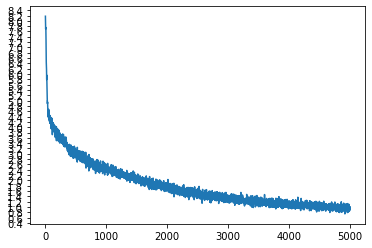

In [48]:
 
hidden_size = 256
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

# print(os.path.exists('/home/yulia/github/Project_DVCVQA_ver1/helping/caption_data/checkpoint_encoder_dir/'))
trainIters(encoder1, attn_decoder1, 500000, print_every=5000)  


In [49]:
#save encoder output features 
def encoder_output(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        
        for ei in range(input_length):
            
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        
        return encoder_outputs

    
text2feature_dct = {}

for question_text in question_text2file.keys():
    question_text = preprocess_sentence(question_text)
    encoder_outputs = encoder_output(encoder1, attn_decoder1, question_text)
    text2feature_dct[question_text2file[question_text]] = encoder_outputs

print('done')

done


In [50]:
import numpy as np
import h5py
import tables 
    
h5file = tables.open_file('question_data/ques_feat1.h5', 'w')

for i in text2feature_dct.keys():
    h5file.create_array('/', str(i), text2feature_dct[i].cpu().numpy())
    
h5file.close()
print('done')

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: Natural

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '435'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '436'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '437'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: N

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '918'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '919'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '920'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: N

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '1368'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '1369'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '1370'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '1875'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '1876'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '1877'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '2363'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '2364'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '2365'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '2842'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '2843'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '2844'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '3334'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '3335'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '3336'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '3806'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '3807'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '3808'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '4272'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '4273'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '4274'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '4779'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '4780'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '4781'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '5281'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '5282'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '5283'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '5758'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '5759'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '5760'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '6229'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '6230'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '6231'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '6736'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '6737'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '6738'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '7239'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '7240'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '7241'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '7745'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '7746'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '7747'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '8218'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '8219'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '8220'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '8724'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '8725'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '8726'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '9228'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '9229'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '9230'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '9684'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '9685'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '9686'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '10146'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '10147'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '10148'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '10637'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '10638'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '10639'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '11122'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '11123'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '11124'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '11574'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '11575'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '11576'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '12063'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '12064'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '12065'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '12551'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '12552'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '12553'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '13026'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '13027'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '13028'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '13482'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '13483'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '13484'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '13965'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '13966'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '13967'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '14433'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '14434'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '14435'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '14899'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '14900'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '14901'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '15383'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '15384'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '15385'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '15857'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '15858'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '15859'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '16329'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '16330'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '16331'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '16705'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '16706'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '16707'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '17180'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '17181'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '17182'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:

/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '17661'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '17662'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: '17663'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python3/dist-packages/tables/path.py:

done


In [53]:
h5file = tables.open_file('question_data/ques_feat1.h5', 'a')

# for i in range(3):
#     tensor = torch.tensor(h5file.get_node('/' + str(i)).read())

for node in h5file.walk_nodes():
    print(node)
h5file.close()

/ (RootGroup) ''
/0 (Array(15, 256)) ''
/1 (Array(15, 256)) ''
/10 (Array(15, 256)) ''
/100 (Array(15, 256)) ''
/1000 (Array(15, 256)) ''
/10000 (Array(15, 256)) ''
/10001 (Array(15, 256)) ''
/10002 (Array(15, 256)) ''
/10003 (Array(15, 256)) ''
/10004 (Array(15, 256)) ''
/10005 (Array(15, 256)) ''
/10006 (Array(15, 256)) ''
/10007 (Array(15, 256)) ''
/10008 (Array(15, 256)) ''
/10009 (Array(15, 256)) ''
/1001 (Array(15, 256)) ''
/10010 (Array(15, 256)) ''
/10011 (Array(15, 256)) ''
/10012 (Array(15, 256)) ''
/10013 (Array(15, 256)) ''
/10014 (Array(15, 256)) ''
/10015 (Array(15, 256)) ''
/10016 (Array(15, 256)) ''
/10017 (Array(15, 256)) ''
/10018 (Array(15, 256)) ''
/10019 (Array(15, 256)) ''
/1002 (Array(15, 256)) ''
/10020 (Array(15, 256)) ''
/10021 (Array(15, 256)) ''
/10022 (Array(15, 256)) ''
/10023 (Array(15, 256)) ''
/10024 (Array(15, 256)) ''
/10025 (Array(15, 256)) ''
/10026 (Array(15, 256)) ''
/10027 (Array(15, 256)) ''
/10028 (Array(15, 256)) ''
/10029 (Array(15, 256)) ''


/10429 (Array(15, 256)) ''
/1043 (Array(15, 256)) ''
/10430 (Array(15, 256)) ''
/10431 (Array(15, 256)) ''
/10432 (Array(15, 256)) ''
/10433 (Array(15, 256)) ''
/10434 (Array(15, 256)) ''
/10435 (Array(15, 256)) ''
/10436 (Array(15, 256)) ''
/10437 (Array(15, 256)) ''
/10438 (Array(15, 256)) ''
/10439 (Array(15, 256)) ''
/1044 (Array(15, 256)) ''
/10440 (Array(15, 256)) ''
/10441 (Array(15, 256)) ''
/10442 (Array(15, 256)) ''
/10443 (Array(15, 256)) ''
/10444 (Array(15, 256)) ''
/10445 (Array(15, 256)) ''
/10446 (Array(15, 256)) ''
/10447 (Array(15, 256)) ''
/10448 (Array(15, 256)) ''
/10449 (Array(15, 256)) ''
/1045 (Array(15, 256)) ''
/10450 (Array(15, 256)) ''
/10451 (Array(15, 256)) ''
/10452 (Array(15, 256)) ''
/10453 (Array(15, 256)) ''
/10454 (Array(15, 256)) ''
/10455 (Array(15, 256)) ''
/10456 (Array(15, 256)) ''
/10457 (Array(15, 256)) ''
/10458 (Array(15, 256)) ''
/10459 (Array(15, 256)) ''
/1046 (Array(15, 256)) ''
/10460 (Array(15, 256)) ''
/10461 (Array(15, 256)) ''
/1046

/10935 (Array(15, 256)) ''
/10936 (Array(15, 256)) ''
/10937 (Array(15, 256)) ''
/10938 (Array(15, 256)) ''
/10939 (Array(15, 256)) ''
/1094 (Array(15, 256)) ''
/10940 (Array(15, 256)) ''
/10941 (Array(15, 256)) ''
/10942 (Array(15, 256)) ''
/10943 (Array(15, 256)) ''
/10944 (Array(15, 256)) ''
/10945 (Array(15, 256)) ''
/10946 (Array(15, 256)) ''
/10947 (Array(15, 256)) ''
/10948 (Array(15, 256)) ''
/10949 (Array(15, 256)) ''
/1095 (Array(15, 256)) ''
/10950 (Array(15, 256)) ''
/10951 (Array(15, 256)) ''
/10952 (Array(15, 256)) ''
/10953 (Array(15, 256)) ''
/10954 (Array(15, 256)) ''
/10955 (Array(15, 256)) ''
/10956 (Array(15, 256)) ''
/10957 (Array(15, 256)) ''
/10958 (Array(15, 256)) ''
/10959 (Array(15, 256)) ''
/1096 (Array(15, 256)) ''
/10960 (Array(15, 256)) ''
/10961 (Array(15, 256)) ''
/10962 (Array(15, 256)) ''
/10963 (Array(15, 256)) ''
/10964 (Array(15, 256)) ''
/10965 (Array(15, 256)) ''
/10966 (Array(15, 256)) ''
/10967 (Array(15, 256)) ''
/10968 (Array(15, 256)) ''
/109

/11568 (Array(15, 256)) ''
/11569 (Array(15, 256)) ''
/1157 (Array(15, 256)) ''
/11570 (Array(15, 256)) ''
/11571 (Array(15, 256)) ''
/11572 (Array(15, 256)) ''
/11573 (Array(15, 256)) ''
/11574 (Array(15, 256)) ''
/11575 (Array(15, 256)) ''
/11576 (Array(15, 256)) ''
/11577 (Array(15, 256)) ''
/11578 (Array(15, 256)) ''
/11579 (Array(15, 256)) ''
/1158 (Array(15, 256)) ''
/11580 (Array(15, 256)) ''
/11581 (Array(15, 256)) ''
/11582 (Array(15, 256)) ''
/11583 (Array(15, 256)) ''
/11584 (Array(15, 256)) ''
/11585 (Array(15, 256)) ''
/11586 (Array(15, 256)) ''
/11587 (Array(15, 256)) ''
/11588 (Array(15, 256)) ''
/11589 (Array(15, 256)) ''
/1159 (Array(15, 256)) ''
/11590 (Array(15, 256)) ''
/11591 (Array(15, 256)) ''
/11592 (Array(15, 256)) ''
/11593 (Array(15, 256)) ''
/11594 (Array(15, 256)) ''
/11595 (Array(15, 256)) ''
/11596 (Array(15, 256)) ''
/11597 (Array(15, 256)) ''
/11598 (Array(15, 256)) ''
/11599 (Array(15, 256)) ''
/116 (Array(15, 256)) ''
/1160 (Array(15, 256)) ''
/11600 

/12075 (Array(15, 256)) ''
/12076 (Array(15, 256)) ''
/12077 (Array(15, 256)) ''
/12078 (Array(15, 256)) ''
/12079 (Array(15, 256)) ''
/1208 (Array(15, 256)) ''
/12080 (Array(15, 256)) ''
/12081 (Array(15, 256)) ''
/12082 (Array(15, 256)) ''
/12083 (Array(15, 256)) ''
/12084 (Array(15, 256)) ''
/12085 (Array(15, 256)) ''
/12086 (Array(15, 256)) ''
/12087 (Array(15, 256)) ''
/12088 (Array(15, 256)) ''
/12089 (Array(15, 256)) ''
/1209 (Array(15, 256)) ''
/12090 (Array(15, 256)) ''
/12091 (Array(15, 256)) ''
/12092 (Array(15, 256)) ''
/12093 (Array(15, 256)) ''
/12094 (Array(15, 256)) ''
/12095 (Array(15, 256)) ''
/12096 (Array(15, 256)) ''
/12097 (Array(15, 256)) ''
/12098 (Array(15, 256)) ''
/12099 (Array(15, 256)) ''
/121 (Array(15, 256)) ''
/1210 (Array(15, 256)) ''
/12100 (Array(15, 256)) ''
/12101 (Array(15, 256)) ''
/12102 (Array(15, 256)) ''
/12103 (Array(15, 256)) ''
/12104 (Array(15, 256)) ''
/12105 (Array(15, 256)) ''
/12106 (Array(15, 256)) ''
/12107 (Array(15, 256)) ''
/12108

/12601 (Array(15, 256)) ''
/12602 (Array(15, 256)) ''
/12603 (Array(15, 256)) ''
/12604 (Array(15, 256)) ''
/12605 (Array(15, 256)) ''
/12606 (Array(15, 256)) ''
/12607 (Array(15, 256)) ''
/12608 (Array(15, 256)) ''
/12609 (Array(15, 256)) ''
/1261 (Array(15, 256)) ''
/12610 (Array(15, 256)) ''
/12611 (Array(15, 256)) ''
/12612 (Array(15, 256)) ''
/12613 (Array(15, 256)) ''
/12614 (Array(15, 256)) ''
/12615 (Array(15, 256)) ''
/12616 (Array(15, 256)) ''
/12617 (Array(15, 256)) ''
/12618 (Array(15, 256)) ''
/12619 (Array(15, 256)) ''
/1262 (Array(15, 256)) ''
/12620 (Array(15, 256)) ''
/12621 (Array(15, 256)) ''
/12622 (Array(15, 256)) ''
/12623 (Array(15, 256)) ''
/12624 (Array(15, 256)) ''
/12625 (Array(15, 256)) ''
/12626 (Array(15, 256)) ''
/12627 (Array(15, 256)) ''
/12628 (Array(15, 256)) ''
/12629 (Array(15, 256)) ''
/1263 (Array(15, 256)) ''
/12630 (Array(15, 256)) ''
/12631 (Array(15, 256)) ''
/12632 (Array(15, 256)) ''
/12633 (Array(15, 256)) ''
/12634 (Array(15, 256)) ''
/126

/13065 (Array(15, 256)) ''
/13066 (Array(15, 256)) ''
/13067 (Array(15, 256)) ''
/13068 (Array(15, 256)) ''
/13069 (Array(15, 256)) ''
/1307 (Array(15, 256)) ''
/13070 (Array(15, 256)) ''
/13071 (Array(15, 256)) ''
/13072 (Array(15, 256)) ''
/13073 (Array(15, 256)) ''
/13074 (Array(15, 256)) ''
/13075 (Array(15, 256)) ''
/13076 (Array(15, 256)) ''
/13077 (Array(15, 256)) ''
/13078 (Array(15, 256)) ''
/13079 (Array(15, 256)) ''
/1308 (Array(15, 256)) ''
/13080 (Array(15, 256)) ''
/13081 (Array(15, 256)) ''
/13082 (Array(15, 256)) ''
/13083 (Array(15, 256)) ''
/13084 (Array(15, 256)) ''
/13085 (Array(15, 256)) ''
/13086 (Array(15, 256)) ''
/13087 (Array(15, 256)) ''
/13088 (Array(15, 256)) ''
/13089 (Array(15, 256)) ''
/1309 (Array(15, 256)) ''
/13090 (Array(15, 256)) ''
/13091 (Array(15, 256)) ''
/13092 (Array(15, 256)) ''
/13093 (Array(15, 256)) ''
/13094 (Array(15, 256)) ''
/13095 (Array(15, 256)) ''
/13096 (Array(15, 256)) ''
/13097 (Array(15, 256)) ''
/13098 (Array(15, 256)) ''
/130

/13790 (Array(15, 256)) ''
/13791 (Array(15, 256)) ''
/13792 (Array(15, 256)) ''
/13793 (Array(15, 256)) ''
/13794 (Array(15, 256)) ''
/13795 (Array(15, 256)) ''
/13796 (Array(15, 256)) ''
/13797 (Array(15, 256)) ''
/13798 (Array(15, 256)) ''
/13799 (Array(15, 256)) ''
/138 (Array(15, 256)) ''
/1380 (Array(15, 256)) ''
/13800 (Array(15, 256)) ''
/13801 (Array(15, 256)) ''
/13802 (Array(15, 256)) ''
/13803 (Array(15, 256)) ''
/13804 (Array(15, 256)) ''
/13805 (Array(15, 256)) ''
/13806 (Array(15, 256)) ''
/13807 (Array(15, 256)) ''
/13808 (Array(15, 256)) ''
/13809 (Array(15, 256)) ''
/1381 (Array(15, 256)) ''
/13810 (Array(15, 256)) ''
/13811 (Array(15, 256)) ''
/13812 (Array(15, 256)) ''
/13813 (Array(15, 256)) ''
/13814 (Array(15, 256)) ''
/13815 (Array(15, 256)) ''
/13816 (Array(15, 256)) ''
/13817 (Array(15, 256)) ''
/13818 (Array(15, 256)) ''
/13819 (Array(15, 256)) ''
/1382 (Array(15, 256)) ''
/13820 (Array(15, 256)) ''
/13821 (Array(15, 256)) ''
/13822 (Array(15, 256)) ''
/13823

/1433 (Array(15, 256)) ''
/14330 (Array(15, 256)) ''
/14331 (Array(15, 256)) ''
/14332 (Array(15, 256)) ''
/14333 (Array(15, 256)) ''
/14334 (Array(15, 256)) ''
/14335 (Array(15, 256)) ''
/14336 (Array(15, 256)) ''
/14337 (Array(15, 256)) ''
/14338 (Array(15, 256)) ''
/14339 (Array(15, 256)) ''
/1434 (Array(15, 256)) ''
/14340 (Array(15, 256)) ''
/14341 (Array(15, 256)) ''
/14342 (Array(15, 256)) ''
/14343 (Array(15, 256)) ''
/14344 (Array(15, 256)) ''
/14345 (Array(15, 256)) ''
/14346 (Array(15, 256)) ''
/14347 (Array(15, 256)) ''
/14348 (Array(15, 256)) ''
/14349 (Array(15, 256)) ''
/1435 (Array(15, 256)) ''
/14350 (Array(15, 256)) ''
/14351 (Array(15, 256)) ''
/14352 (Array(15, 256)) ''
/14353 (Array(15, 256)) ''
/14354 (Array(15, 256)) ''
/14355 (Array(15, 256)) ''
/14356 (Array(15, 256)) ''
/14357 (Array(15, 256)) ''
/14358 (Array(15, 256)) ''
/14359 (Array(15, 256)) ''
/1436 (Array(15, 256)) ''
/14360 (Array(15, 256)) ''
/14361 (Array(15, 256)) ''
/14362 (Array(15, 256)) ''
/1436

/14819 (Array(15, 256)) ''
/1482 (Array(15, 256)) ''
/14820 (Array(15, 256)) ''
/14821 (Array(15, 256)) ''
/14822 (Array(15, 256)) ''
/14823 (Array(15, 256)) ''
/14824 (Array(15, 256)) ''
/14825 (Array(15, 256)) ''
/14826 (Array(15, 256)) ''
/14827 (Array(15, 256)) ''
/14828 (Array(15, 256)) ''
/14829 (Array(15, 256)) ''
/1483 (Array(15, 256)) ''
/14830 (Array(15, 256)) ''
/14831 (Array(15, 256)) ''
/14832 (Array(15, 256)) ''
/14833 (Array(15, 256)) ''
/14834 (Array(15, 256)) ''
/14835 (Array(15, 256)) ''
/14836 (Array(15, 256)) ''
/14837 (Array(15, 256)) ''
/14838 (Array(15, 256)) ''
/14839 (Array(15, 256)) ''
/1484 (Array(15, 256)) ''
/14840 (Array(15, 256)) ''
/14841 (Array(15, 256)) ''
/14842 (Array(15, 256)) ''
/14843 (Array(15, 256)) ''
/14844 (Array(15, 256)) ''
/14845 (Array(15, 256)) ''
/14846 (Array(15, 256)) ''
/14847 (Array(15, 256)) ''
/14848 (Array(15, 256)) ''
/14849 (Array(15, 256)) ''
/1485 (Array(15, 256)) ''
/14850 (Array(15, 256)) ''
/14851 (Array(15, 256)) ''
/1485

/15331 (Array(15, 256)) ''
/15332 (Array(15, 256)) ''
/15333 (Array(15, 256)) ''
/15334 (Array(15, 256)) ''
/15335 (Array(15, 256)) ''
/15336 (Array(15, 256)) ''
/15337 (Array(15, 256)) ''
/15338 (Array(15, 256)) ''
/15339 (Array(15, 256)) ''
/1534 (Array(15, 256)) ''
/15340 (Array(15, 256)) ''
/15341 (Array(15, 256)) ''
/15342 (Array(15, 256)) ''
/15343 (Array(15, 256)) ''
/15344 (Array(15, 256)) ''
/15345 (Array(15, 256)) ''
/15346 (Array(15, 256)) ''
/15347 (Array(15, 256)) ''
/15348 (Array(15, 256)) ''
/15349 (Array(15, 256)) ''
/1535 (Array(15, 256)) ''
/15350 (Array(15, 256)) ''
/15351 (Array(15, 256)) ''
/15352 (Array(15, 256)) ''
/15353 (Array(15, 256)) ''
/15354 (Array(15, 256)) ''
/15355 (Array(15, 256)) ''
/15356 (Array(15, 256)) ''
/15357 (Array(15, 256)) ''
/15358 (Array(15, 256)) ''
/15359 (Array(15, 256)) ''
/1536 (Array(15, 256)) ''
/15360 (Array(15, 256)) ''
/15361 (Array(15, 256)) ''
/15362 (Array(15, 256)) ''
/15363 (Array(15, 256)) ''
/15364 (Array(15, 256)) ''
/153

/15953 (Array(15, 256)) ''
/15954 (Array(15, 256)) ''
/15955 (Array(15, 256)) ''
/15956 (Array(15, 256)) ''
/15957 (Array(15, 256)) ''
/15958 (Array(15, 256)) ''
/15959 (Array(15, 256)) ''
/1596 (Array(15, 256)) ''
/15960 (Array(15, 256)) ''
/15961 (Array(15, 256)) ''
/15962 (Array(15, 256)) ''
/15963 (Array(15, 256)) ''
/15964 (Array(15, 256)) ''
/15965 (Array(15, 256)) ''
/15966 (Array(15, 256)) ''
/15967 (Array(15, 256)) ''
/15968 (Array(15, 256)) ''
/15969 (Array(15, 256)) ''
/1597 (Array(15, 256)) ''
/15970 (Array(15, 256)) ''
/15971 (Array(15, 256)) ''
/15972 (Array(15, 256)) ''
/15973 (Array(15, 256)) ''
/15974 (Array(15, 256)) ''
/15975 (Array(15, 256)) ''
/15976 (Array(15, 256)) ''
/15977 (Array(15, 256)) ''
/15978 (Array(15, 256)) ''
/15979 (Array(15, 256)) ''
/1598 (Array(15, 256)) ''
/15980 (Array(15, 256)) ''
/15981 (Array(15, 256)) ''
/15982 (Array(15, 256)) ''
/15983 (Array(15, 256)) ''
/15984 (Array(15, 256)) ''
/15985 (Array(15, 256)) ''
/15986 (Array(15, 256)) ''
/159

/16432 (Array(15, 256)) ''
/16433 (Array(15, 256)) ''
/16434 (Array(15, 256)) ''
/16435 (Array(15, 256)) ''
/16436 (Array(15, 256)) ''
/16437 (Array(15, 256)) ''
/16438 (Array(15, 256)) ''
/16439 (Array(15, 256)) ''
/1644 (Array(15, 256)) ''
/16440 (Array(15, 256)) ''
/16441 (Array(15, 256)) ''
/16442 (Array(15, 256)) ''
/16443 (Array(15, 256)) ''
/16444 (Array(15, 256)) ''
/16445 (Array(15, 256)) ''
/16446 (Array(15, 256)) ''
/16447 (Array(15, 256)) ''
/16448 (Array(15, 256)) ''
/16449 (Array(15, 256)) ''
/1645 (Array(15, 256)) ''
/16450 (Array(15, 256)) ''
/16451 (Array(15, 256)) ''
/16452 (Array(15, 256)) ''
/16453 (Array(15, 256)) ''
/16454 (Array(15, 256)) ''
/16455 (Array(15, 256)) ''
/16456 (Array(15, 256)) ''
/16457 (Array(15, 256)) ''
/16458 (Array(15, 256)) ''
/16459 (Array(15, 256)) ''
/1646 (Array(15, 256)) ''
/16460 (Array(15, 256)) ''
/16461 (Array(15, 256)) ''
/16462 (Array(15, 256)) ''
/16463 (Array(15, 256)) ''
/16464 (Array(15, 256)) ''
/16465 (Array(15, 256)) ''
/164

KeyboardInterrupt: 

In [58]:
evaluateRandomly(encoder1, attn_decoder1)

> 2745
= what is the gender of the person in a red swimsuit
< what is the gender of the person in a red clothes <EOS>

> 8108
= what is the occupation of the people standing on the side of the stage
< what is the right of the people standing on the left of the video <EOS>

> 2126
= what is behind the net
< what is behind the car <EOS>

> 13774
= is the woman wearing a cowboy long or short hair
< is the woman wearing a watch long or short hair <EOS>

> 71
= is the person in white trouser a woman
< is the person in white orange a woman <EOS>

> 9967
= what happens before the person in the video swab the board
< what happens before the person in the video is the rope <EOS>

> 12240
= is the horse in the room
< is the horse in the room <EOS>

> 6052
= what happened to the person in red after he plugged in the wire
< what happened to the person in red after he played in the plaid <EOS>

> 568
= how many judges are there on the court
< how many many are there on the game <EOS>

> 3400
= what

In [25]:
learning_rate=0.0001

hidden_size = 256
device = "cuda" if torch.cuda.is_available() else "cpu"

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)


checkpoint_encoder_dir = '/home/yulia/github/Project_DVCVQA_ver1/helping/caption_data/checkpoint_encoder_dir/'
checkpoint_decoder_dir = '/home/yulia/github/Project_DVCVQA_ver1/helping/caption_data/checkpoint_decoder_dir/'

if os.path.exists(os.path.join(checkpoint_encoder_dir, 'checkpoint.pt')):
    ckp_path = checkpoint_encoder_dir
    encoder, encoder_optimizer, start_epoch = load_ckp(ckp_path, encoder, encoder_optimizer)

    ckp_path = checkpoint_decoder_dir
    decoder, decoder_optimizer, start_epoch = load_ckp(ckp_path, decoder, decoder_optimizer)

encoder.eval()
decoder.eval()

print('decoder.load_state_dict', decoder.load_state_dict)

decoder.load_state_dict <bound method Module.load_state_dict of AttnDecoderRNN(
  (embedding): Embedding(6444, 256)
  (attn): Linear(in_features=512, out_features=15, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=6444, bias=True)
)>


In [55]:
evaluateRandomly(encoder1, attn_decoder1)

> 7107
= what is the color of the hockey stick


TypeError: tensorFromSentence() takes 1 positional argument but 2 were given